In [1]:
import pyspark
import pandas as pd
#import datefinder
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import re   
import seaborn as sns
import statsmodels.api as sm
#from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
#from fbprophet import Prophet
#import pmdarima as pm
#from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import requests
from pyspark.sql.types import *

In [2]:
sc = pyspark.SparkContext(appName="Spark RDD")

In [3]:
#Remove tuple with len !=14
def RemoveStrangeTupleLen(tup):
    if len(tup)==14:
        return tup
    
#CLEANING MAC_ADDRESS_SRC FIELD
def RemoveQuoteSrc(tup):
    if tup[0][0]=='"':
        tup[0]=tup[0][1:]
    return tup

def RemoveWeirdAddress(tup):
    if len(tup[0])>17:
        tup[0]=None
    return tup

#CLEANING CAT FIELD
def CATToInt(tup): 
    tup[1] = int(tup[1])
    return tup

#CLEANING TID FIELD
def replaceNullValue_TID(tup):
    if tup[2] != '' and tup[2] != None and tup[2] != 'NaN': 
        return tup
    else: 
        tup[2] = ''
        return tup
    
#CLEANING TS FIELD
def TSToFloat(tup): 
    tup[3] = float(round(float(tup[3])))
    return tup

#CLEANING DST FIELD
#None

#CLEANING SAC FIELD
def replaceNullValue_SAC(tup):
    if tup[5] != '' and tup[5] != None and tup[5] != 'NaN': 
        tup[5] = float(tup[5])
        return tup
    else: 
        tup[5] = None
        return tup

#CLEANING SIC FIELD
def replaceNullValue_SIC(tup):
    if tup[6] != '' and tup[6] != None and tup[6] != 'NaN': 
        tup[6] = float(tup[6])
        return tup
    else: 
        tup[6] = None
        return tup
    
#CLEANING ToD FIELD
def replaceNullValue_ToD(tup):
    if tup[7] != '' and tup[7] != None and tup[7] != 'NaN': 
        tup[7] = float(tup[7])
        return tup
    else: 
        tup[7] = None
        return tup

#CLEANING TN FIELD
def replaceNullValue_TN(tup):
    if tup[8] != '' and tup[8] != None and tup[8] != 'NaN': 
        tup[8] = float(tup[8])
        return tup
    else: 
        tup[8] = None
        return tup

#CLEANING THETA FIELD
def replaceNullValue_THETA(tup):
    if tup[9] != '' and tup[9] != None and tup[9] != 'NaN': 
        tup[9] = float(tup[9])
        return tup
    else: 
        tup[9] = None
        return tup

#CLEANING RHO FIELD
def replaceNullValue_RHO(tup):
    if tup[10] != '' and tup[10] != None and tup[10] != 'NaN': 
        tup[10] = float(tup[10])
        return tup
    else: 
        tup[10] = None
        return tup
    
#CLEANING FL FIELD 
def replaceNullValue_FL(tup):
    if tup[11] != '' and tup[11] != None and tup[11] != 'NaN': 
        tup[11] = float(tup[11])
        return tup
    else: 
        tup[11] = None
        return tup
    
#CLEANING CGS FIELD
def replaceNullValue_CGS(tup):
    if tup[12] != '' and tup[12] != None and tup[12] != 'NaN': 
        tup[12] = float(tup[12])
        return tup
    else: 
        tup[12] = None
        return tup
    
#CLEANING CHdg FIELD
    
def replaceNullValue_CHdg(tup):
    if tup[13] != '' and tup[13] != None and tup[13] != 'NaN': 
        tup[13] = float(tup[13])
        return tup
    else: 
        tup[13] = None
        return tup
    
def RemoveQuoteCHdg(tup):
    if tup[13][-1]=='"':
        tup[13]=tup[13][:-1]
    return tup


def cleaning(tup):
    tup = RemoveQuoteSrc(tup)
    tup = RemoveWeirdAddress(tup)
    tup = CATToInt(tup)
    tup = replaceNullValue_TID(tup)
    tup = TSToFloat(tup)
    tup = replaceNullValue_SAC(tup)
    tup = replaceNullValue_SIC(tup)
    tup = replaceNullValue_ToD(tup)
    tup = replaceNullValue_TN(tup) 
    tup = replaceNullValue_THETA(tup)
    tup = replaceNullValue_RHO(tup)
    tup = replaceNullValue_FL(tup)
    tup = replaceNullValue_CGS(tup)
    tup = replaceNullValue_CHdg(RemoveQuoteCHdg(tup))
    return tup
    
def main_clean(rdd):
    
    rdd = rdd.map(lambda tup: cleaning(tup))
    return(rdd)

In [4]:
def getlistavion(): 
    QUERY = 'SELECT DISTINCT(TID) FROM global_temp.traffic'
    return spark.sql(QUERY).toPandas()

def main_db(rdd): 
    global traffic_df_explicit, trafficSchema, spark  
    
    traffic_df_explicit_aux = spark.createDataFrame(rdd, trafficSchema)
    traffic_df_explicit = traffic_df_explicit.unionAll(traffic_df_explicit_aux)       
    
    traffic_df_explicit.createOrReplaceGlobalTempView('traffic')
    
    traffic_df_explicit.cache()

In [127]:
spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-SQL").getOrCreate()

trafficSchema = StructType ( [StructField("SRC", StringType(), True),
                                 StructField("CAT", LongType(), True),
                                 StructField("TID", StringType(), True),
                                 StructField("TS", DoubleType(), True),
                                 StructField("DST", StringType(), True),
                                 StructField("SAC", DoubleType(), True),
                                 StructField("SIC", DoubleType(), True),
                                 StructField("ToD", DoubleType(), True),
                                 StructField("TN", DoubleType(), True),
                                 StructField("THETA", DoubleType(), True),
                                 StructField("RHO", DoubleType(), True),
                                 StructField("FL", DoubleType(), True),
                                 StructField("CGS", DoubleType(), True),
                                 StructField("CHdg", DoubleType(), True),
                             ] )
    
traffic_df_explicit = spark.createDataFrame(spark.sparkContext.emptyRDD(),trafficSchema)
traffic_df_explicit.createOrReplaceGlobalTempView('traffic')

response = requests.get('http://192.168.37.142:50005/stream/2019-05-04-12:00:00/2019-05-04-16:00:00', stream = True)

i = 0
list_aux = [] 
for data in response.iter_lines():
    list_aux.append(data.decode("UTF-8").split(","))
    
    
    i = i + 1
    if not(i % 10000):
        print(i)
        
    if (i==100000): break 

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [131]:
rdd_traffic = sc.parallelize(list_aux)
rdd_traffic_clean = main_clean(rdd_traffic)
main_db(rdd_traffic_clean) 

In [132]:
spark.sql("select TID, count(*) from global_temp.traffic group by TID order by count(*) DESC").show()

+--------+--------+
|     TID|count(1)|
+--------+--------+
|        |   20678|
|JAF3ML  |     242|
|KLM1503 |     241|
|RYR3119 |     239|
|TVF98ZQ |     238|
|TVF168  |     238|
|CSDTZ   |     232|
|KLM587  |     229|
|CCM543M |     228|
|EZY64WY |     227|
|RAM775L |     226|
|RYR72ZZ |     225|
|ACA891  |     224|
|VJT585  |     222|
|AFR78LC |     221|
|AFR96PF |     220|
|EZY8185 |     218|
|EZY92UD |     218|
|TAM8070 |     214|
|CCM778K |     213|
+--------+--------+
only showing top 20 rows



In [121]:
spark.sql("select * from global_temp.traffic where TID LIKE '%BAW45MA%'").show()

+-----------------+---+--------+-------------+-----------------+---+----+-------------+------+-------------+------------+------+-------------+-------------+
|              SRC|CAT|     TID|           TS|              DST|SAC| SIC|          ToD|    TN|        THETA|         RHO|    FL|          CGS|         CHdg|
+-----------------+---+--------+-------------+-----------------+---+----+-------------+------+-------------+------------+------+-------------+-------------+
|00:23:9c:c1:94:5f| 48|BAW45MA |1.556976196E9|01:00:5e:50:00:26|8.0| 9.0|48194.8203125|1231.0|356.561279297|   16.609375|379.75|401.440429688|325.349121094|
|00:23:9c:c1:94:5f| 48|BAW45MA |1.556976196E9|01:00:5e:50:00:46|8.0|17.0|48194.6640625|1692.0|17.3858642578|199.40234375|379.75|413.305664062| 322.05871582|
|00:23:9c:c1:94:5f| 48|BAW45MA |1.556976196E9|01:00:5e:50:00:06|8.0| 1.0| 48194.359375|1417.0|292.263793945|121.62109375|379.75|402.099609375|326.848754883|
|00:23:9c:c1:94:5f| 48|BAW45MA |1.556976196E9|01:00:5e:50:

In [7]:
def getlistavion(): 
    QUERY = 'SELECT DISTINCT(TID) FROM global_temp.traffic'
    return spark.sql(QUERY).toPandas()

In [ ]:
getlistavion()

Un avion, x radars

In [119]:
def getPacketsByPlane(tid):
    TID = '\'%' + tid + '%\'' 
    QUERY = 'SELECT * FROM global_temp.traffic \
            WHERE TID LIKE ' + str(TID)
    #print(QUERY)
    return spark.sql(QUERY).toPandas()

def dictRadarsByAvion(TID, list_radar_aux=list()):
    df_temp = getPacketsByPlane(TID)
    list_radar = list(df_temp.groupby('DST').size().index)
    dictRadar = {}
    for dst in list_radar:
        if len(list_radar_aux) > 0: 
            if dst in list_radar_aux:
                #dictRadar[dst] = filterByPlaneAndRadar(TID, dst) ##TOO MUCH TIME
                dictRadar[dst] = df_temp[df_temp['DST'] == dst]
        else: 
            dictRadar[dst] = df_temp[df_temp['DST'] == dst]
    return dictRadar

import colorsys
import random
colorsys.hsv_to_rgb(359,100,100)
def randomColor(i, m):
    return rgb_to_hex(colorsys.hsv_to_rgb(float(i) / float(m), 1, 1))
def rgb_to_hex(rgb):
    rgbInt = (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
    return '#%02x%02x%02x' % rgbInt

def plotRadar(dictRadar, var=None):
    if len(dictRadar) > 0: 
        if var == None:
            for var in list(dictRadar[list(dictRadar.keys())[0]].columns):
                i, m = 0, len(dictRadar.keys())
                for dst in dictRadar.keys():
                    plt.plot(dictRadar[dst]['TS'], dictRadar[dst][var], randomColor(i, m))
                    i = i + 1
                plt.xlabel('time(s)')
                plt.ylabel(var)
                plt.show()            
        else:
            i, m = 0, len(dictRadar.keys())
            for dst in dictRadar.keys():
                plt.plot(dictRadar[dst]['TS'], dictRadar[dst][var], randomColor(i, m))
                i = i + 1
            plt.xlabel('time(s)')
            plt.ylabel(var)
            plt.show()
        
        
        
def viz1(dictRadar, TID):
    
    plotRadar(dictRadar)
    
    #sns.pairplot(data=getPacketsByPlane(TID), vars=['SAC', 'SIC', 'ToD', 'TN', 'THETA', 'RHO', 'FL', 'CGS', 'CHdg'])
    #plt.show()
    
    #sns.heatmap(data=getPacketsByPlane(TID)[['SIC', 'ToD', 'TN', 'THETA', 'FL', 'CGS', 'CHdg']].corr(), annot = True, cmap = 'Reds')
    #plt.show()

In [120]:
viz1(dictRadarsByAvion('JAF3ML', list_radar_aux = ('01:00:5e:50:01:42')), 'JAF3ML')

Un radar, x avions

In [133]:
def getPacketsByRadar(dst):
    DST = '\'%' + dst + '%\'' 
    QUERY = 'SELECT * FROM global_temp.traffic \
            WHERE DST LIKE ' + str(DST)
    #print(QUERY)
    return spark.sql(QUERY).toPandas()

def dictPlanesByRadar(DST, list_planes_aux=list()):
    df_temp = getPacketsByRadar(DST)
    list_planes = list(df_temp.groupby('TID').size().index)
    dictPlanes = {}
    for tid in list_planes:
        if len(list_planes_aux) > 0:  
            if tid != '' and tid.strip() in list_planes_aux:
                #dictRadar[dst] = filterByPlaneAndRadar(TID, dst) ##TOO MUCH TIME
                #print(tid)
                dictPlanes[tid] = df_temp[df_temp['TID'] == tid]
        else: 
            dictPlanes[tid] = df_temp[df_temp['TID'] == tid]
    return dictPlanes

import colorsys
import random
colorsys.hsv_to_rgb(359,100,100)
def randomColor(i, m):
    return rgb_to_hex(colorsys.hsv_to_rgb(float(i) / float(m), 1, 1))
def rgb_to_hex(rgb):
    rgbInt = (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
    return '#%02x%02x%02x' % rgbInt

def plotRadar(dict, var=None):
        if var == None:
            for var in list(dict[list(dict.keys())[0]].columns):
                i, m = 0, len(dict.keys())
                for dst in dict.keys():
                    plt.plot(dict[dst]['TS'], dict[dst][var], randomColor(i, m))
                    i = i + 1
                plt.xlabel('time(s)')
                plt.ylabel(var)
                plt.show()            
        else:
            i, m = 0, len(dict.keys())
            for dst in dict.keys():
                plt.plot(dict[dst]['TS'], dict[dst][var], randomColor(i, m))
                i = i + 1
            plt.xlabel('time(s)')
            plt.ylabel(var)
            plt.show()  
        
        
def viz3(dict, DST):
    
    plotRadar(dict)
    
    #sns.pairplot(data=getPacketsByPlane(TID), vars=['SAC', 'SIC', 'ToD', 'TN', 'THETA', 'RHO', 'FL', 'CGS', 'CHdg'])
    #plt.show()
    
    #sns.heatmap(data=getPacketsByPlane(TID)[['SIC', 'ToD', 'TN', 'THETA', 'FL', 'CGS', 'CHdg']].corr(), annot = True, cmap = 'Reds')
    #plt.show()

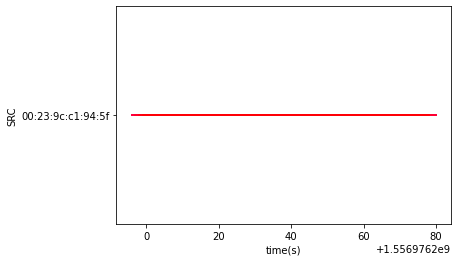

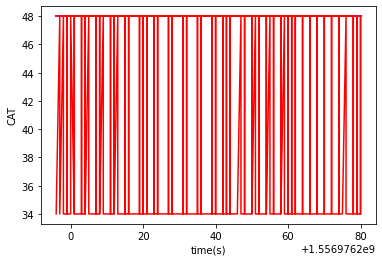

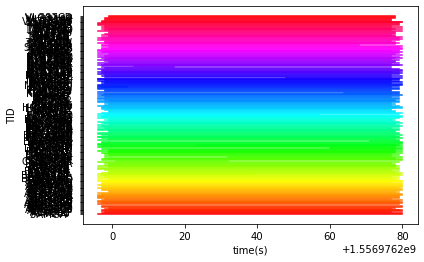

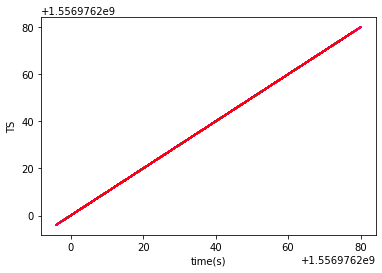

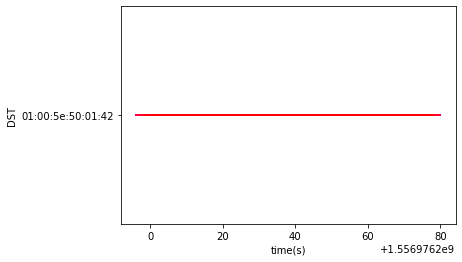

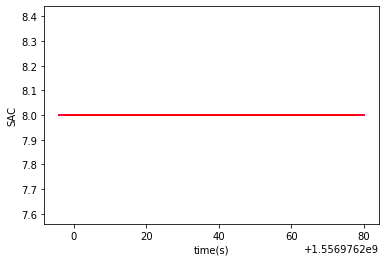

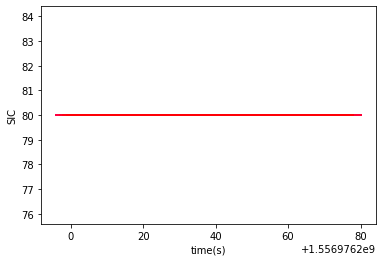

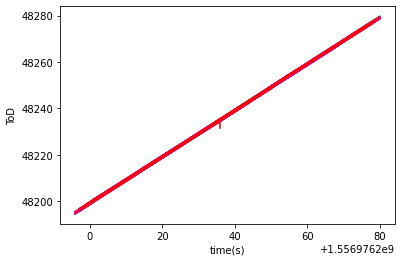

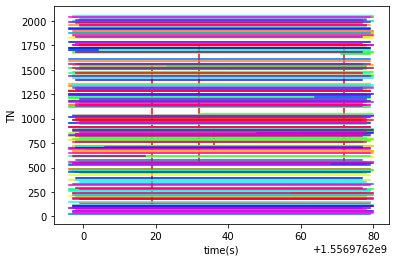

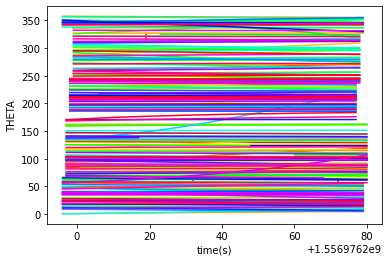

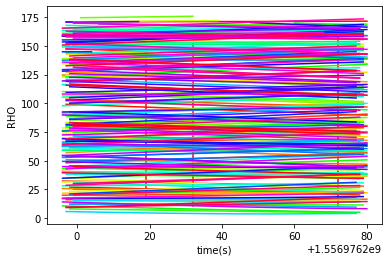

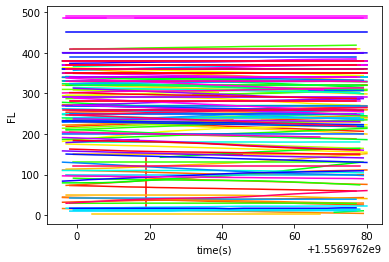

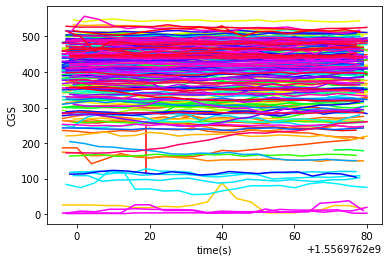

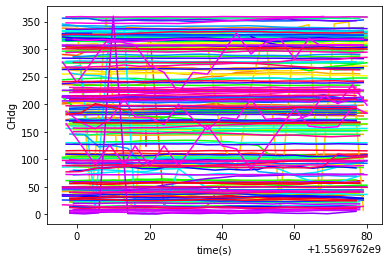

In [136]:
viz3(dictPlanesByRadar('01:00:5e:50:01:42'), '01:00:5e:50:01:42')

In [106]:
dictPlanesByRadar('01:00:5e:50:01:42', list_planes_aux=('JAF3ML'))

{'JAF3ML  ':                     SRC  CAT       TID            TS                DST  SAC  \
 161   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 415   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 669   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 923   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 1177  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 1431  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 1686  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 1940  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 2194  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 2449  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 2704  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
 2957  00:23:9c:

In [104]:
list_planes_aux = ('JAF3ML')
df_temp = getPacketsByRadar('01:00:5e:50:01:42')
dictPlanes = {}
list_planes = list(df_temp.groupby('TID').size().index)

#print(list_radar)

for tid in list_planes:
    #print(tid)
    if len(list_planes_aux) > 0: 
        #print(tid.strip())
        #print(list_planes_aux)
        if tid != '' and tid.strip() in list_planes_aux:
                #print(type(tid))
                #dictRadar[dst] = filterByPlaneAndRadar(TID, dst) ##TOO MUCH TIME
                #print(tid)
                dictPlanes[tid] = df_temp[df_temp['TID'] == tid]
    else: 
        dictPlanes[tid] = df_temp[df_temp['TID'] == tid]

print(dictPlanes)

{'JAF3ML  ':                     SRC  CAT       TID            TS                DST  SAC  \
161   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
415   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
669   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
923   00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
1177  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
1431  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
1686  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
1940  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
2194  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
2449  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
2704  00:23:9c:c1:94:5f   48  JAF3ML    1.556976e+09  01:00:5e:50:01:42  8.0   
2957  00:23:9c:c1:94:5f   4

In [103]:
dictPlanesByRadar('01:00:5e:50:01:42', list_planes_aux = ('JA3ML'))

{}

In [ ]:
def filterByPlaneAndRadar(tid, dst):
    TID = '\'%' + tid + '%\'' 
    DST = '\'%' + dst + '%\'' 
    QUERY = 'SELECT * FROM global_temp.traffic WHERE TID LIKE ' + str(TID) + ' AND DST LIKE ' +  str(DST) 
    return spark.sql(QUERY).toPandas()

def plotOneRadarForOnePlane(df_radar_avion):
    for var in df_radar_avion.columns:
        plt.plot(df_radar_avion['TS'], df_radar_avion[var])
        plt.xlabel('time(s)')
        plt.ylabel(var)
        plt.show() 
        
def viz2(df_radar_avion):
    
    plotOneRadarForOnePlane(df_radar_avion)
    
    #sns.pairplot(data=df_radar_avion, vars=['SAC', 'SIC', 'ToD', 'TN', 'THETA', 'RHO', 'FL', 'CGS', 'CHdg'])
    #plt.show()
    
    #sns.heatmap(data=df_radar_avion[['SIC', 'ToD', 'TN', 'THETA', 'FL', 'CGS', 'CHdg']].corr(), annot = True, cmap = 'Reds')
    #plt.show()

In [ ]:
viz2(filterByPlaneAndRadar('JAF3ML', '01:00:5e:50:01:42'))

In [ ]:
from threading import Thread

In [ ]:
def request_plane(list):
    if(len(list)==1):
        TID=list[0]
        viz1(dictRadar=dictRadarsByAvion(TID),TID=TID)
    else:
        TID=list[0]
        SRC=list[1] 
        viz2(filterByPlaneAndRadar(TID, SRC))

In [ ]:
myargs=['JAF3ML', '01:00:5e:50:01:42']
TH = Thread(target = request_plane, args=(myargs,))
TH.start()

In [ ]:
spark.sql("select count(*) from global_temp.traffic").toPandas()

In [ ]:
-> un avion, tous les radars : bon 
-> un avion, quelques radars : bon 
-> un avion, un radars : bon 